In [1]:
! wget "https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz"
! tar -xzf "/content/domain_sentiment_data.tar.gz"

--2024-12-03 04:44:30--  https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz
Resolving www.cs.jhu.edu (www.cs.jhu.edu)... 128.220.13.64
Connecting to www.cs.jhu.edu (www.cs.jhu.edu)|128.220.13.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30586147 (29M) [application/x-gzip]
Saving to: ‘domain_sentiment_data.tar.gz’

domain_sentiment_da 100%[===================>]  29.17M  8.53MB/s    in 3.4s    

2024-12-03 04:44:35 (8.53 MB/s) - ‘domain_sentiment_data.tar.gz’ saved [30586147/30586147]



In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import re
from pickle import dump
from pickle import load

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import gensim
import gensim.downloader as api

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense, Embedding, TimeDistributed
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
from nltk.tokenize import word_tokenize
def clean_sentence(sentence: str) -> list:
  # Remove the review tag
  tags = re.compile("(|<\/review_text>)")
  sentence = re.sub(tags, '', sentence)

  # lower case
  sentence = sentence.lower()

  # Remove emails and urls
  email_urls = re.compile("(\bhttp.+? | \b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b)")
  sentence = re.sub(email_urls, '', sentence)

  # Some used '@' to hide offensive words (bla -> bl@)
  ats = re.compile('@')
  sentence = re.sub(ats, 'a', sentence)

  # Remove Punctuation
  # punc = re.compile("[!\"\#$\%\&\'\*\+,\-\.\/\:;<=>\?
  punc = re.compile("[^\w\s(\w+\-\w+)]")
  sentence = re.sub(punc, '', sentence)

  # Remove stopwords and tokenize
  # sentence = sentence.split(sep=' ')
  sentence = word_tokenize(sentence)
  sentence = [word for word in sentence if not word in stopwords.words()]

  # Stemming (Returning to root)
  # stemmer = PorterStemmer()
  # sentence = [stemmer.stem(word) for word in sentence]


  return sentence

In [4]:
# Read files
path = "/content/sorted_data_acl/"
regex_review = re.compile(".+?<\/review_text>", flags=re.DOTALL)

# Training Data
folders = ["books","dvd","electronics"]
x_train = list()
y_train = list()
print('Reading Train Data')
for folder in folders:
  temp = open(path+folder+"/negative.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Negative reviews from",folder)
  for sentence in temp:
    x_train.append(clean_sentence(sentence))
    y_train.append(0)


  temp = open(path+folder+"/positive.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Positive reviews from",folder)
  for sentence in temp:
    x_train.append(clean_sentence(sentence))
    y_train.append(1)



# Test data
folders = ["kitchen_&_housewares"]
x_test = list()
y_test = list()
print('Reading Test Data')
for folder in folders:
  temp = open(path+folder+"/negative.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Negative reviews from",folder)
  for sentence in temp:
    x_test.append(clean_sentence(sentence))
    y_test.append(0)


  temp = open(path+folder+"/positive.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Positive reviews from",folder)
  for sentence in temp:
    x_test.append(clean_sentence(sentence))
    y_test.append(1)


Reading Train Data
Reading 1000 Negative reviews from books
Reading 1000 Positive reviews from books
Reading 1000 Negative reviews from dvd
Reading 1000 Positive reviews from dvd
Reading 1000 Negative reviews from electronics
Reading 1000 Positive reviews from electronics
Reading Test Data
Reading 1000 Negative reviews from kitchen_&_housewares
Reading 1000 Positive reviews from kitchen_&_housewares


In [5]:
temp_file = open('x_train','wb')
save_x_train = dump(x_train, temp_file)
temp_file.close()

temp_file = open('y_train','wb')
save_y_train = dump(y_train, temp_file)
temp_file.close()

temp_file = open('x_test','wb')
save_x_test = dump(x_test, temp_file)
temp_file.close()

temp_file = open('y_test','wb')
save_y_test = dump(y_test, temp_file)
temp_file.close()

Max size: 1728
Min size: 43
Top 10 sizes: [535, 540, 540, 544, 551, 575, 589, 602, 629, 633, 639, 639, 644, 647, 662, 677, 686, 754, 1083, 1728]
From  0.0 to 20.0 : 0.0
From  20.0 to 40.0 : 0.0
From  40.0 to 60.0 : 651.0
From  60.0 to 80.0 : 1495.0
From  80.0 to 100.0 : 1334.0
From  100.0 to 120.0 : 736.0
From  120.0 to 140.0 : 509.0
From  140.0 to 160.0 : 320.0
From  160.0 to 180.0 : 218.0
From  180.0 to 200.0 : 157.0
From  200.0 to 300.0 : 407.0


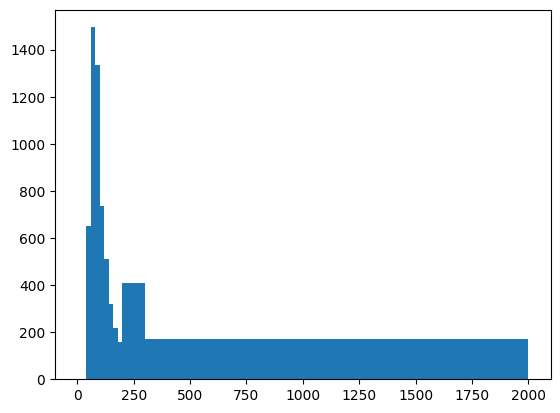

In [6]:
lengths = [len(sentence) for sentence in x_train]
lengths.sort()
print("Max size:", max(lengths))
print("Min size:", min(lengths))
print("Top 10 sizes:",lengths[-20:])
counts,bins,_ = plt.hist(lengths,bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 2000])
for i in range(len(counts)-1):
  print('From ',bins[i],'to',bins[i+1],':',counts[i])

plt.show()

In [7]:
vocab = set()
for sentence in x_train:
  for word in sentence:
    vocab.add(word)

vocab.add('') # for dummy words, to avoid adding a word that has a meaning
print("Vocab size:", len(vocab))

# Make a mapping betwween words and their IDs
word2id = {word:id for  id, word in enumerate(vocab)}
id2word = {id:word for  id, word in enumerate(vocab)}

Vocab size: 82841


In [8]:

def encode_sentence(old_sentence):
  encoded_sentence = []
  dummy = word2id['']
  for word in old_sentence:
    try:
      encoded_sentence.append(word2id[word])
    except KeyError:
      encoded_sentence.append(dummy) # the none char

  return encoded_sentence


# Encoding train sentences
x_train_encoded = []
for sentence in x_train:
  x_train_encoded.append(encode_sentence(sentence))

# Encoding test sentences
x_test_encoded = []
for sentence in x_test:
  x_test_encoded.append(encode_sentence(sentence))

print("Len train:", len(x_train_encoded))
print("Len test:", len(x_test_encoded))

Len train: 6000
Len test: 2000


In [9]:
MAX_SEQ_LEN = 125
dummy = word2id['']
# Padding train sentences
x_train_padded = pad_sequences(x_train_encoded, maxlen=MAX_SEQ_LEN, dtype='int', padding='post', truncating='post', value=dummy)
print("Train shape: ",x_train_padded.shape)

# Padding test sentences
x_test_padded = pad_sequences(x_test_encoded, maxlen=MAX_SEQ_LEN, dtype='int', padding='post', truncating='post', value=dummy)
print("Test shape: ", x_test_padded.shape)

Train shape:  (6000, 125)
Test shape:  (2000, 125)


In [10]:
y_train = np.array(y_train)
temp, = y_train.shape
y_train = y_train.reshape((temp,1))
y_train.shape

y_test = np.array(y_test)
temp, = y_test.shape
y_test = y_test.reshape((temp,1))
y_test.shape

(2000, 1)

In [11]:
w2v = api.load('glove-twitter-200')
w2v.most_similar("mahmoud")


[==================================================] 100.0% 758.5/758.5MB downloaded


[('mohamed', 0.71284019947052),
 ('mostafa', 0.689501166343689),
 ('ahmed', 0.6817302703857422),
 ('mohey', 0.6513986587524414),
 ('ahmadinejad', 0.6093316674232483),
 ('mohammed', 0.5743428468704224),
 ('youssef', 0.5647962689399719),
 ('morsi', 0.5544598698616028),
 ('hassan', 0.554221510887146),
 ('fouad', 0.5403571724891663)]

In [12]:
num_words = len(vocab)
embed_size, = w2v['mahmoud'].shape
embedding_matrix = np.zeros(shape=(num_words, embed_size))

for word, id in word2id.items():
  try:
    embedding_matrix[id] = w2v[word]
  except KeyError:
    embedding_matrix[id] = np.zeros(embed_size)

embedding_matrix.shape


(82841, 200)

In [13]:
num_words = len(vocab)
embed_size, = w2v['mahmoud'].shape
embedding_matrix = np.zeros(shape=(num_words, embed_size))

for word, id in word2id.items():
  try:
    embedding_matrix[id] = w2v[word]
  except KeyError:
    embedding_matrix[id] = np.zeros(embed_size)

embedding_matrix.shape


(82841, 200)

In [14]:
lstm_model = Sequential(name='Rating')

lstm_model.add(Input(shape=(MAX_SEQ_LEN,), dtype='int32'))
lstm_model.add(Embedding(input_dim = len(vocab),            # Vocabulary Size (number of unique words for training)
                        output_dim = embed_size,            # Length of the vector for each word (embedding dimension)
                        input_length = MAX_SEQ_LEN,         # Maximum length of a sequence
                        weights = [embedding_matrix],       # Send the needed glove-twitter-200 Weights
                        trainable = False))

lstm_model.add(LSTM(units = 30,
                    return_sequences=True,
                    # dropout=0.5,
                    # recurrent_dropout=0.5
                    )
              )
lstm_model.add(LSTM(units = 30,
                    # return_sequences=True,
                    # dropout=0.5,
                    # recurrent_dropout=0.5
                    )
              )
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
lstm_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Rating"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 125, 200)            │      16,568,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 125, 30)             │          27,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30)                  │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,603,271 (63.34 MB)

 Trainable params: 35,071 (137.00 KB)

 Non-trainable params: 16,568,200 (63.20 MB)

In [15]:
train_data, train_labels = shuffle(x_train_padded, y_train, random_state=42)

In [16]:
lstm_model.fit(train_data,
               train_labels,
               validation_split=0.20,
               batch_size = 50,
               epochs = 50)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5143 - loss: 0.6925 - val_accuracy: 0.5183 - val_loss: 0.6924
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5457 - loss: 0.6906 - val_accuracy: 0.5225 - val_loss: 0.6907
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5444 - loss: 0.6870 - val_accuracy: 0.5567 - val_loss: 0.6830
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6017 - loss: 0.6631 - val_accuracy: 0.6800 - val_loss: 0.6217
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6907 - loss: 0.6101 - val_accuracy: 0.7117 - val_loss: 0.5868
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7077 - loss: 0.5890 - val_accuracy: 0.7292 - val_loss: 0.5741
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7337 - loss: 0.5567 - val_accuracy: 0.7325 - val_loss: 0.5601
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7435 - loss: 0.5490 - val_accuracy: 0.7475 - v

In [17]:
l, a = lstm_model.evaluate(x_test_padded, y_test)
print("Test accuracy:", round(a*100,2),"%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7663 - loss: 0.5615
Test accuracy: 80.4 %


In [18]:
def lstm_predict(sentence:str):
  sentence = clean_sentence(sentence)
  # Encode sentence
  ready_sentence = encode_sentence(sentence)
  # Padding sentence
  ready_sentence = pad_sequences(sequences = [ready_sentence],
                                 maxlen=MAX_SEQ_LEN,
                                 dtype='int32',
                                 padding='post',
                                 truncating='post',
                                 value = dummy)

  # Predict
  prediction = round(lstm_model.predict(ready_sentence)[0][0])
  if prediction==0:
    print("Negative Review")
  elif prediction==1:
    print("Positive Review")
  else:
    print('Error')


In [19]:
lstm_predict("I really recommend this book")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Positive Review


In [20]:
lstm_predict("I don't know what the hell did i just read, the book is full nonsense")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Negative Review


In [21]:
lstm_model.save('lstm_w_770.h5',save_format='h5')

In [22]:
lstm_model.save('model.keras',save_format='keras')